In [1]:
%%capture
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from tensorflow.keras import regularizers
import os
import time
import numpy as np
import gc
import zipfile
from tensorflow.keras.models import model_from_json
!pip install tqdm
!pip install h5py
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from sklearn import preprocessing

In [2]:
def scale(x):

    return (x - np.mean(x)) / np.std(x)

In [3]:
def preprocess(x):
    
    return x[:,:,:int(0.75*75)]#x.shape[2])]

In [4]:
def cut(x, switch):
    temp = []
    size = int(x.shape[0] / 5)
    for i in range(5):
        temp.append(x[i * size:(i + 1) * size])
    x = np.array(temp)
    
    if switch:
        x = np.reshape(x, (5,-1))
    
    return x

In [5]:
#os.chdir("/Users/michelkauffmann/Downloads/dscaptstone-master/Re15sh20_DNScoarse8")
u = preprocess(scale(loadmat('u_F_xyz_T1.mat')["u_F"]))
v = preprocess(scale(loadmat('v_F_xyz_T1.mat')["v_F"]))
w = preprocess(scale(loadmat('w_F_xyz_T1.mat')["w_F"]))
tau_12 = preprocess(scale(loadmat('tau12_xyz_T1.mat')["tau12"]))
tau_13 = preprocess(scale(loadmat('tau13_xyz_T1.mat')["tau13"]))
tau_23 = preprocess(scale(loadmat('tau23_xyz_T1.mat')["tau23"]))
tke = preprocess(scale(loadmat("TKE_F_xyz_T1.mat")["TKE_F"]))
theta = preprocess(scale(loadmat("theta_F_xyz_T1.mat")["theta_F"]))

In [6]:
all_taus = False
significance = True

### Create Datasets

In [7]:
x = np.array([u, v, w, tke, theta])
x = np.transpose(x, [1, 2, 3, 0])
#x = np.reshape(x, (1, x.shape[0], x.shape[1], x.shape[2], x.shape[3]))
print(x.shape)
x = cut(x, False)
print(x.shape)

(146, 96, 56, 5)
(5, 29, 96, 56, 5)


In [8]:
x_base = np.delete(x, (3,4), 4)
print(x_base.shape)
x_theta = np.delete(x, 3, 4)
print(x_theta.shape)
x_tke = np.delete(x, 4, 4)
print(x_tke.shape)
del x
gc.collect()

(5, 29, 96, 56, 3)
(5, 29, 96, 56, 4)
(5, 29, 96, 56, 4)


11

In [9]:
tau_12 = cut(tau_12, True)#np.reshape(tau_12, (1, -1))
print(tau_12.shape)
tau_13 = cut(tau_13, True)#np.reshape(tau_13, (1, -1))
print(tau_12.shape)
tau_23 = cut(tau_23, True)#np.reshape(tau_23, (1, -1))
print(tau_23.shape)

(5, 155904)
(5, 155904)
(5, 155904)


### Create Model Class 

In [10]:
class CNN(object):
    
    def __init__(self, activation, initializer, regularizer, x_train, y_train, epochs, batch_size, input_shape, filter_size, val_split, x_val, y_val):
        self.activation = activation
        self.initializer = initializer
        self.regularizer = regularizer
        self.x_train = x_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.filter = filter_size
        self.val_split = val_split
        self.x_val = x_val
        self.y_val = y_val
        
        pass 
    
    def create_model(self):
        model = keras.Sequential([
            tf.keras.layers.Conv3D(128,
                             kernel_size = self.filter,
                             activation = self.activation,
                             input_shape = input_shape,   
                             padding = "same",
                             kernel_regularizer = self.regularizer,
                             data_format = 'channels_last'),
            tf.keras.layers.AveragePooling3D(pool_size = (29,96,56)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(self.y_train.shape[1])
        ])
        
        return model
    
    def callbacks(self):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               min_delta = 0.001,
                                               patience = 0,
                                               verbose = 0)
        
        return early_stopping
    
    def run_model(self):
        model = self.create_model()
        model.compile(optimizer = tf.train.AdamOptimizer(), 
              loss = "mse")
        
        #model.summary()
            
        history = model.fit(self.x_train, self.y_train, 
                    epochs = self.epochs, 
                    #validation_split = self.val_split, 
                    validation_data = (self.x_val, self.y_val),
                    batch_size =  self.batch_size,
                    verbose = 0)
                    #callbacks = [self.callbacks()])
        
        return history, model

###  Compare TKE, $\theta$ and Base

Training on x_base
R^2: -0.1867
Correlation: 0.0091

Training on x_tke
R^2: -0.1551
Correlation: 0.0108

Training on x_theta
R^2: -0.1802
Correlation: 0.0069



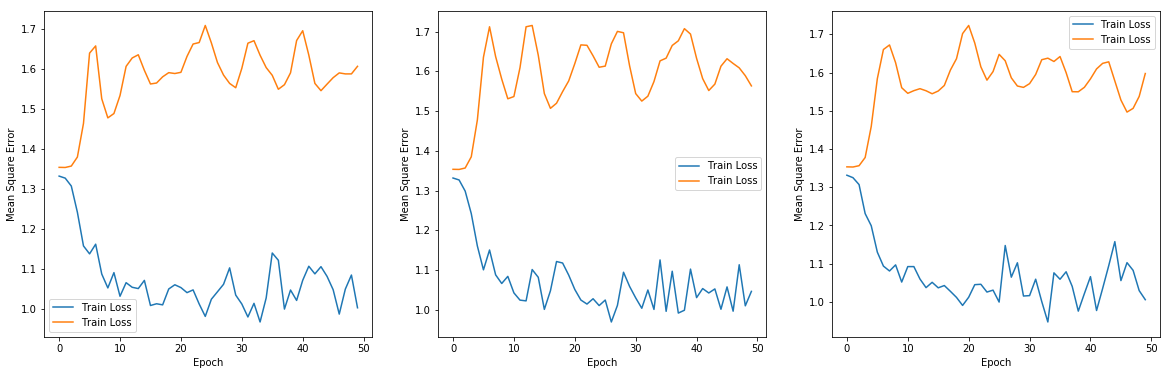

0

In [11]:
if significance:
    activation = tf.nn.relu
    initializer = None
    regularizer = None
    epochs = 50
    batch_size = 1
    filter_size = (7,7,7)
    val_split = 0.0

    datasets = [(x_base, "x_base"), (x_tke, "x_tke"), (x_theta, "x_theta")]
    fig = plt.figure(figsize = (20, 6))
    results = {}
    i = 1
    for (x, name) in datasets:
        print("Training on " + name)
        
        x_train, x_val = x[1:], x[0]
        x_val = x_val.reshape((1, x_val.shape[0], x_val.shape[1], x_val.shape[2], x_val.shape[3]))
        y_train, y_val = tau_12[1:], tau_12[0]
        y_val = y_val.reshape((1, y_val.shape[0]))
        
        input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3], x_train.shape[4])
        model = CNN(activation, initializer, regularizer, x_train, y_train, epochs, batch_size, input_shape, filter_size, val_split, x_val, y_val)
        history, model = model.run_model()
        
        fig.add_subplot(1, len(datasets), i)
        plt.plot(history.epoch, np.array(history.history['loss']), label = 'Train Loss')
        plt.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Square Error')
        plt.legend()

        y_pred = model.predict(x_val).flatten()
        y_true = y_val.flatten()
        print("R^2: %.4f" % r2_score(y_true, y_pred))
        print("Correlation: %.4f\n" % np.corrcoef(y_pred, y_true)[0, 1])
        results[np.corrcoef(y_pred, y_true)[0, 1]] = x
        
        del x_train
        del x_val
        del y_train
        del y_val
        del model
        del y_pred
        del y_true
        gc.collect()
        i += 1

    plt.show()
del datasets
gc.collect()

In [11]:
"""
x_best = results[max(results)]
print(x_best.shape)
del results
gc.collect()
"""

(1, 146, 96, 56, 4)


0

### Model 3 Tau's

Predicting tau_12
R^2: 0.9513
Correlation: 0.9896
Saved model to disk

Predicting tau_13
R^2: 0.8395
Correlation: 0.9456
Saved model to disk

Predicting tau_23
R^2: 0.8032
Correlation: 0.9645
Saved model to disk



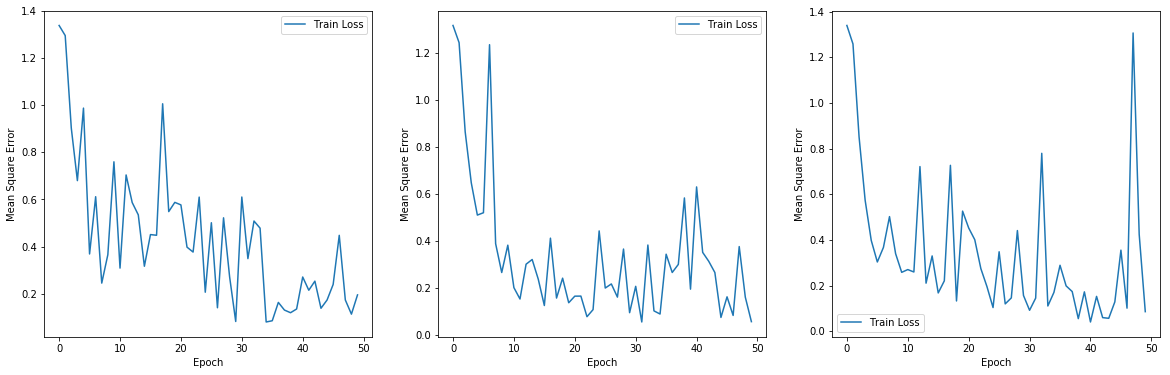

0

In [12]:
"""
if all_taus:
    taus = [(tau_11, "tau_11"), (tau_12, "tau_12"), (tau_13, "tau_13"), (tau_22, "tau_22"), (tau_23, "tau_23"), (tau_33, "tau_33")]
else:
    taus = [(tau_12, "tau_12"), (tau_13, "tau_13"), (tau_23, "tau_23")]

activation = tf.nn.relu
initializer = None
regularizer = None
epochs = 50
batch_size = 1
input_shape = (x_best.shape[1], x_best.shape[2], x_best.shape[3], x_best.shape[4])
filter_size = (7,7,7)
val_split = 0.0

fig = plt.figure(figsize = (20, 6))

i = 1
for (y, name) in taus:
    print("Predicting " + name)
    model = CNN(activation, initializer, regularizer, x_best, y, epochs, batch_size, input_shape, filter_size, val_split)
    history, model = model.run_model()
    
    fig.add_subplot(1, len(taus), i)
    plt.plot(history.epoch, np.array(history.history['loss']), label = 'Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.legend()
    
    y_pred = model.predict(x_best).flatten()
    y_true = y.flatten()
    print("R^2: %.4f" % r2_score(y_true, y_pred))
    print("Correlation: %.4f" % np.corrcoef(y_pred, y_true)[0, 1])
    
    model_name_json = "model_" + name + ".json"
    model_name_h5 = "model_" + name + ".h5"
    model_json = model.to_json()
    with open(model_name_json, "w") as json_file:
        json_file.write(model_json)
    model.save(model_name_h5)
    print("Saved model to disk\n")
    
    del y
    del model
    del y_pred
    del y_true
    gc.collect()
    i += 1

plt.show()
del taus
gc.collect()
"""

### Predict on new Dataset

In [21]:
#file_path = "/home/pk2573/Re15sh2_DNScoarse8.zip"

In [22]:
"""
def un_zip(file_path):
    path, fname = os.path.split(file_path)
    if (fname.endswith("tgz")):
        tar = tarfile.open(fname, "r:gz")
        tar.extractall(path)
        tar.close()
    elif (fname.endswith("tar")):
        tar = tarfile.open(fname, "r:")
        tar.extractall(path)
        tar.close()
    elif (fname.endswith("zip")):
        zip_ref = zipfile.ZipFile(fname, 'r')
        zip_ref.extractall(path)
        zip_ref.close()
            
    new_path = path + "/" + fname.split(".")[0]
    
    return new_path
"""

In [23]:
#path = un_zip(file_path)

In [32]:
"""
u = preprocess(scale(loadmat('u_F_xyz_T1.mat')["u_F"]))
v = preprocess(scale(loadmat('v_F_xyz_T1.mat')["v_F"]))
w = preprocess(scale(loadmat('w_F_xyz_T1.mat')["w_F"]))
tau_12 = preprocess(scale(loadmat('tau12_xyz_T1.mat')["tau12"]))
tke = preprocess(scale(loadmat("TKE_F_xyz_T1.mat")["TKE_F"]))
theta = preprocess(scale(loadmat("theta_F_xyz_T1.mat")["theta_F"]))
"""

(146, 96, 72)


In [33]:
"""
x = np.array([u, v, w, theta])
x = np.transpose(x, [1, 2, 3, 0])
x = np.reshape(x, (1, x.shape[0], x.shape[1], x.shape[2], x.shape[3]))
print(x.shape)
tau_12 = np.reshape(tau_12, (1, -1))
print(tau_12.shape)
"""

(1, 146, 96, 56, 4)
(1, 784896)


In [34]:
"""
json_file = open('model_tau_12.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model_tau_12.h5")
loaded_model.compile(loss = 'mse', optimizer = tf.train.AdamOptimizer())

y_pred = loaded_model.predict(x).flatten()
y_true = tau_12.flatten()
print("R^2: %.4f" % r2_score(y_true, y_pred))
print("Correlation: %.4f" % np.corrcoef(y_pred, y_true)[0, 1])
"""

R^2: -1.7526
Correlation: 0.0007


In [ ]:
#custom_filter = np.ones((7,7,7), dtype = np.float64)